In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
#import pyDOE
from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot

Consider a situation similar to the previous ball drop example; however, now consider different types of balls that have different densities. The four types of balls, baseball, basketball, bowling ball, and softball, are again dropped from a tower. Each type of ball has a unique radius $R$ and density $\rho$. Each ball is dropped from heights of 20, 40, and 60 meters.

We will generate synthetic experimental data from:
\begin{equation}
\frac{d^2h}{dt^2} = g - \frac{C}{2}\frac{3\rho_{air}}{4R_{ball}\rho_{ball}}\bigg(\frac{dh}{dt}\bigg)^2
\end{equation}
where $\rho_{air}=1.184 kg/m^3$ is the density of air, $R_{ball}$ is the radius of the ball, $\rho_{ball}$ is the density of the ball, and $g$ and $C$ are the coefficients of gravity and drag as defined in our previous example. The observation data model is given by equation (1) and $g$ and $C$ are both considered unknown. The goal is to jointly estimate these parameters.

There are three experiments for each type of ball corresponding to the heights of 20, 40, and 60 meters. The baseball, basketball, bowling ball, and softball have radii $0.0380, 0.12, 0.11, 0.0485$ meters and densities $626, 84, 1304, 380.9 \; kg/m^3$. A space filling Latin hypercube design selects the m=20 (C,g) design pairs for the simulator runs, shown in a scatter below. The simulator produces a curve of n=100 height-time pairs, where the simulation heights are evenly spaced in $[0,100]$ meters. Each of these 20 parameter settings are run for each of the four balls.

Read in data

x_obs   : Radius and Density for Baseball, Basketball, Bowling Ball, Softball  
h_obs   : oberservational heights for each experiment  
y_obs   : time-height curve for experiment  

x_sim   : Radius and Density for all simulator runs  
t_sim   : LH generated simulation design points (C,g)
h_sim   : simulator heights  
y_sim   : time-height curve for simulator

In [4]:
import os
datadir = os.getcwd()+"/data/ball_drop_2/"
# experimental data
with open(datadir+'fieldDat12x6gparam.txt','r') as f:
    field_data = np.loadtxt(f)
with open(datadir+'desNative4x2Rrho.txt','r') as f:
    x = np.loadtxt(f) # x = {R, rho_ball}
    
x_obs = x
y_obs = np.reshape(field_data[:,4],(4,3)) # observed times, experiments by row
h_obs = field_data[0:3,3]                 # observed heights

# simulated data
with open(datadir+'desNative80x4Cg.txt','r') as f:
    sim_data = np.loadtxt(f)
x_sim = sim_data[:,0:2] # x = {R, rho_ball}
t_sim = sim_data[:,2:4] # t = {C, g}
with open(datadir+'simHeights101x1','r') as f:
    h_sim = np.loadtxt(f)
with open(datadir+'sims101x80Cg.txt','r') as f:
    y_sim = np.loadtxt(f).T

# create sepia data object
data = SepiaData(x_sim = x_sim, t_sim = t_sim, y_ind_sim = h_sim, y_sim = y_sim,\
                 x_obs = x, y_obs = y_obs, y_ind_obs = h_obs)

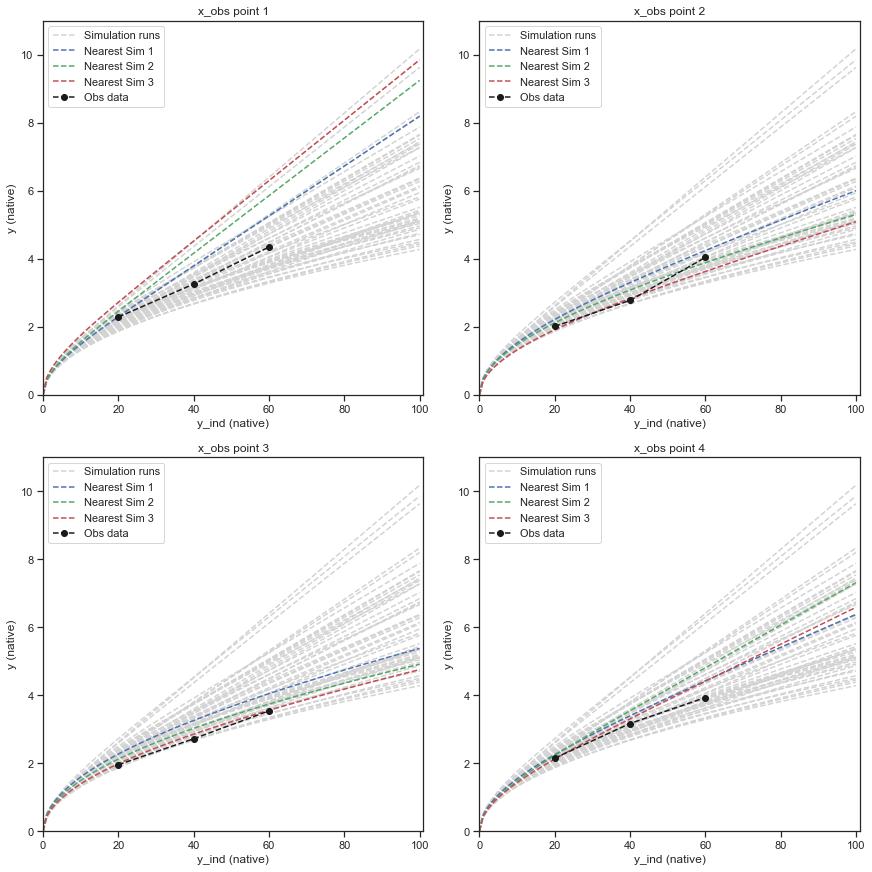

In [5]:
data.plot_data(x_max=101,y_max=11)

t (parameters): Latin Hyper cube design for $(C,g)$ pairs

(Text(0, 0.5, 'C'), Text(0.5, 1.0, 'Simulation Design'))

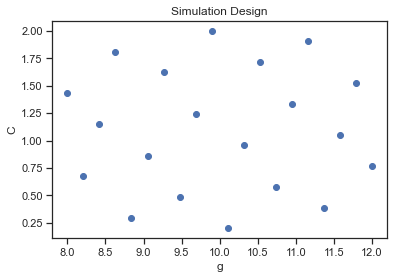

In [6]:
plt.scatter(t_sim[0:20,1],t_sim[0:20,0])
plt.xlabel("g");plt.ylabel("C"),plt.title("Simulation Design")

In [7]:
data.transform_xt()
data.standardize_y()

(5,)


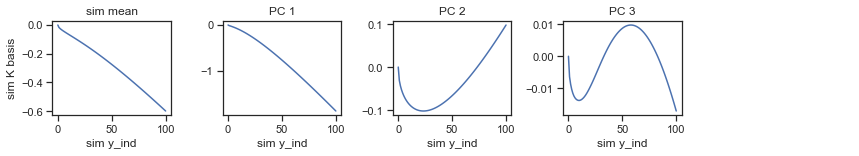

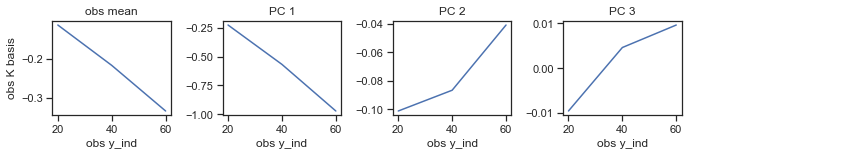

In [8]:
data.create_K_basis(3)
data.plot_K_basis()

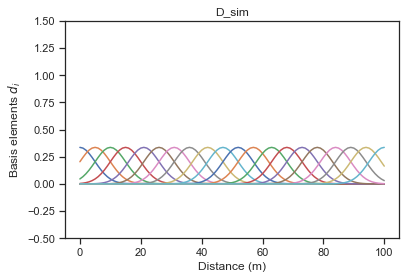

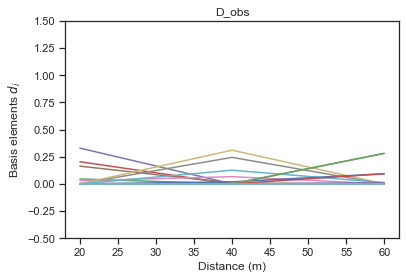

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 101, obs y dimension 3
n  =     4 (number of observed data)
m  =    80 (number of simulated data)
p  =     2 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     3 (transformed response dimension)
pv =    20 (transformed discrepancy dimension)



In [9]:
# Generate D matrix with normal kernels
n_kernels = 20
D_grid = np.linspace(min(h_sim),max(h_sim),n_kernels,dtype=int) # locations on which the kernels are centered
D_width = max(D_grid)/n_kernels  # width of each kernel
pv = len(D_grid)
D_obs = np.zeros(shape=(data.obs_data.y_ind.shape[0],pv))
D_sim = np.zeros(shape=(data.sim_data.y_ind.shape[0],pv))
#h_dense = data_dict['h_dense']
#D_dense = np.zeros(shape=(h_dense.shape[0],pv))

for j in range(pv):
    D_obs[:,j] = norm.pdf(h_obs, D_grid[j], D_width)
    D_sim[:,j] = norm.pdf(h_sim, D_grid[j],D_width)
    #D_dense[:,j] = norm.pdf(h_dense, D_grid[j],D_width)

data.create_D_basis(D_obs=D_obs.T,D_sim=D_sim.T)

plt.ylim(-.5,1.5)
plt.plot(h_sim,D_sim)
plt.xlabel("Distance (m)");plt.ylabel("Basis elements $d_i$");plt.title("D_sim")
plt.show()
plt.ylim(-.5,1.5)
plt.plot(h_obs,D_obs)
plt.xlabel("Distance (m)");plt.ylabel("Basis elements $d_i$");plt.title("D_obs")
plt.show()
print(data)

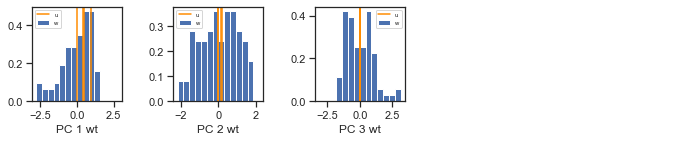

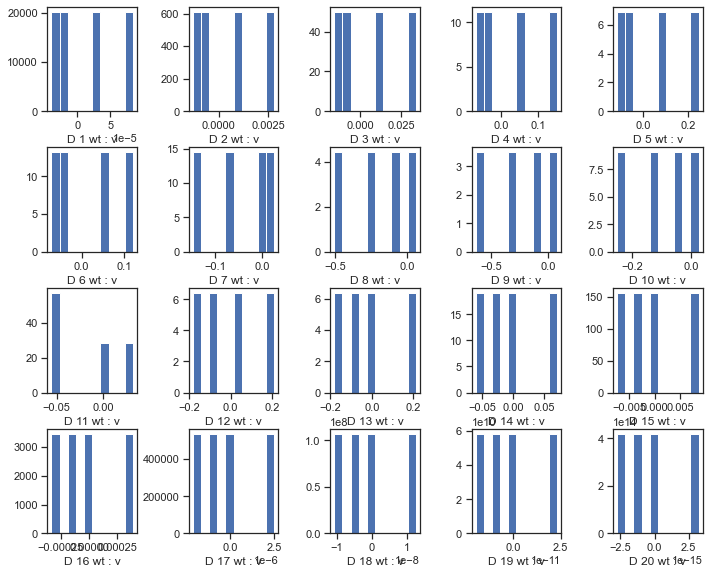

In [10]:
data.plot_K_weights()

Plotting up to 5 pairs. Change with parameter 'max_plots'


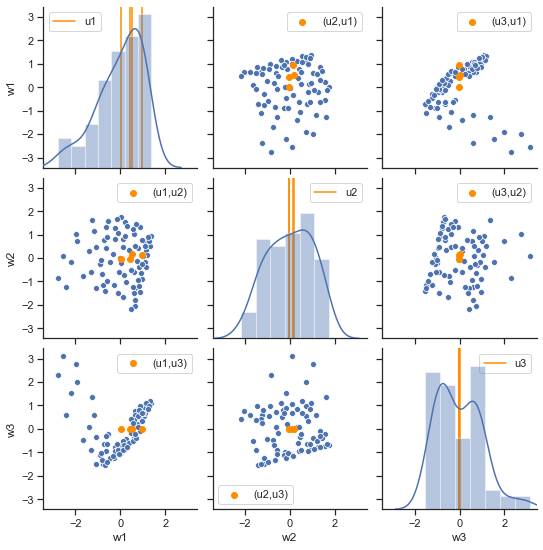

In [11]:
data.plot_u_w_pairs()

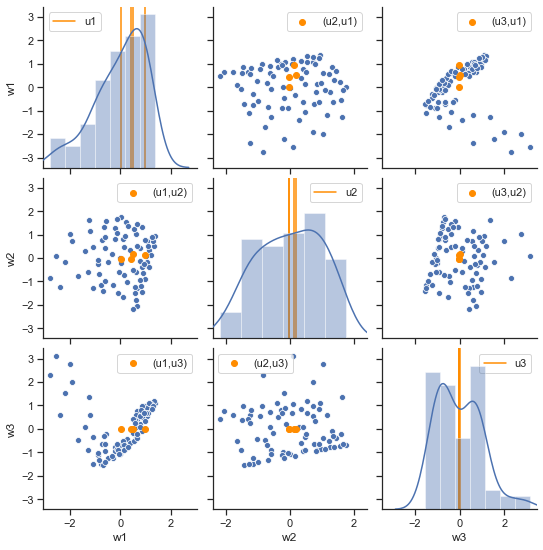

In [12]:
# w pairs plot with horizonal lines for u
pu = data.sim_data.K.shape[0]
w = np.dot(np.linalg.pinv(data.sim_data.K).T, data.sim_data.y_std.T).T
w_df = pd.DataFrame(data=w,columns=('w1','w2','w3'))
pv = data.obs_data.D.shape[0]
DK = np.concatenate([data.obs_data.D, data.obs_data.K])  # (pu+pv, ell_obs)
DKridge = 1e-6 * np.diag(np.ones(pu + pv))  # (pu+pv, pu+pv)
Lamy = np.eye(data.obs_data.y_ind.shape[0])
DKprod = np.linalg.multi_dot([DK, Lamy, DK.T])  # (pu+pv, pu+pv)
vu = np.dot(np.linalg.inv(DKprod + DKridge), np.linalg.multi_dot([DK, Lamy, data.obs_data.y_std.T]))
v = vu[:pv, :].T
u = vu[pv:, :].T

lims = np.maximum(np.max(np.abs(w),axis=0),np.max(np.abs(u),axis=0))*1.1
with sns.plotting_context("notebook", font_scale=1):
    g = sns.PairGrid(w_df)
    g.map_diag(sns.distplot)
    g.map_offdiag(sns.scatterplot)
    for i in range(g.axes.shape[1]): # rows
        for j in range(g.axes.shape[0]): # columns
            g.axes[i,j].set_xlim(-lims[j],lims[j]); g.axes[i,j].set_ylim(-lims[j],lims[j])
            if i == j:
                for k in range(u.shape[0]):
                    g.axes[i,i].axvline(u[k,i],color='darkorange',label='u{}'.format(i+1) if k==0 else "_")
                g.axes[i,i].legend(facecolor='white')
            else:
                g.axes[i,j].scatter(u[:,j],u[:,i],c='darkorange',label='(u{},u{})'.format(j+1,i+1))
                g.axes[i,j].legend(facecolor='white')
plt.show()

In [13]:
model = setup_model(data)
print(model.data.obs_data.K)
cachefile_name='ball_drop_2.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name):
    model=pickle.load(open(cachefile_name, "rb" ))
else:
    model.tune_step_sizes(50, 20)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

lamWOs initialized outside default bounds [60, 1e5]; setting initial value to 1e5 - 1.
[[-0.22635853 -0.56830172 -0.97331744]
 [-0.10137277 -0.08673501 -0.04076598]
 [-0.00960002  0.00459297  0.00962363]]


In [14]:
samples_dict = {p.name: p.mcmc_to_array(trim=1000,untransform_theta=True) for p in model.params.mcmcList}
print(samples_dict['theta'].shape)

(4000, 2)


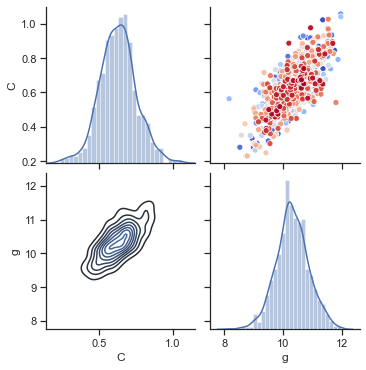

In [15]:
theta_names = ['C','g']
SepiaPlot.theta_pairs(samples_dict,theta_names)

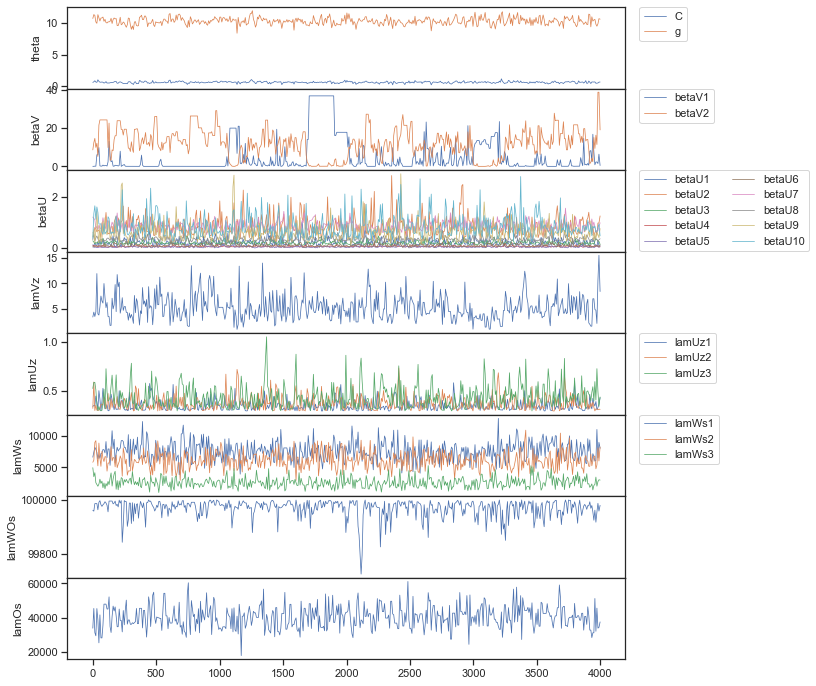

In [16]:
SepiaPlot.mcmc_trace(samples_dict,theta_names)

In [17]:
p_stats = SepiaPlot.param_stats(samples_dict,theta_names,q1=.05,q2=.95,digits=4)
print(np.round(p_stats,4))

                mean         sd  0.05 quantile  0.95 quantile
C             0.6291     0.1269         0.4249         0.8411
g            10.3122     0.5579         9.4240        11.2767
betaV_1       5.1301     9.1298         0.0008        28.2457
betaV_2      11.8371     7.4702         0.0525        24.3229
betaU_1       0.2431     0.1348         0.0955         0.4998
betaU_2       0.8571     0.3517         0.4430         1.5491
betaU_3       0.2127     0.0673         0.1297         0.3392
betaU_4       0.0730     0.0208         0.0459         0.1129
betaU_5       0.0540     0.0281         0.0221         0.1088
betaU_6       0.1167     0.0600         0.0483         0.2328
betaU_7       0.8799     0.1729         0.6167         1.1769
betaU_8       0.3572     0.0882         0.2390         0.5156
betaU_9       0.6291     0.3622         0.2553         1.2145
betaU_10      0.8616     0.4217         0.3588         1.6678
betaU_11      2.7191     0.4906         1.9953         3.5828
betaU_12

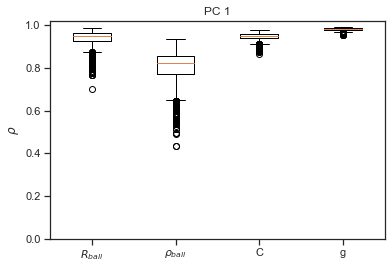

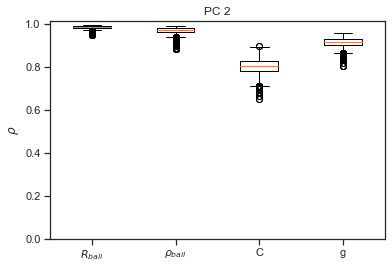

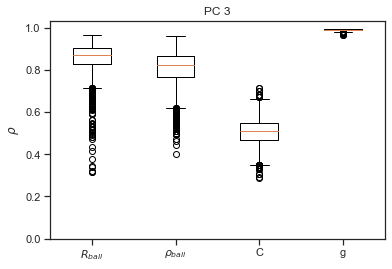

In [18]:
p = model.num.p
q = model.num.q
pu = model.num.pu
# rho box plots
bu = samples_dict['betaU']
ru = np.exp(-bu / 4)
for i in range(pu):
    r = ru[:, ((p+q)*i):((p+q)*i)+(p+q)]
    plt.boxplot(r)
    plt.xticks([1,2,3,4],[r'$R_{ball}$',r'$\rho_{ball}$','C','g'])
    plt.yticks(np.arange(0,1.2,.2))
    plt.ylabel(r'$\rho$')
    plt.title('PC {}'.format(i+1))
    plt.show()

In [19]:
# generic function
#SepiaPlot.rho_box_plots(model,labels=[r'$R_{ball}$',r'$\rho_{ball}$','C','g'])

----
## Predictions of model output from the full model

First, predictions showing just the emulator response, using
SepiaEmulatorPredict

In [20]:
model.verbose=True
from sepia.SepiaPredict import SepiaEmulatorPrediction
pred_samples=model.get_samples(nburn=1000,effectivesamples=True)
pred=SepiaEmulatorPrediction(x_pred=x, samples=pred_samples, model=model)

Max effective sample size over thetas: 303
Total samples: 4000


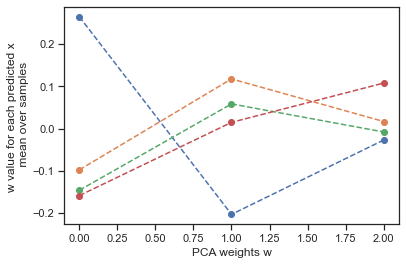

In [21]:
predw=pred.get_w()
plt.figure()
plt.plot(np.mean(predw,0).T,'--o')
plt.xlabel('PCA weights w')
plt.ylabel('w value for each predicted x \n mean over samples')
plt.show()

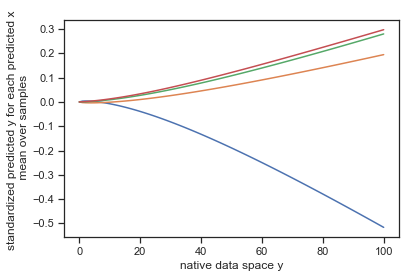

In [22]:
predystd=pred.get_y(std=True)
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predystd,0).T)
plt.xlabel('native data space y')
plt.ylabel('standardized predicted y for each predicted x \n mean over samples')
plt.show()

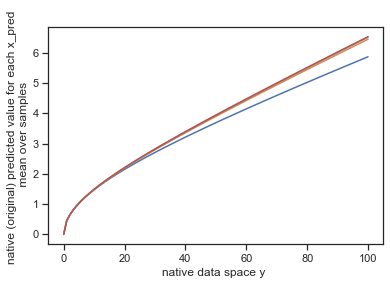

In [23]:
predy=pred.get_y()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy,0).T)
plt.xlabel('native data space y ')
plt.ylabel('native (original) predicted value for each x_pred \n mean over samples')
plt.show()

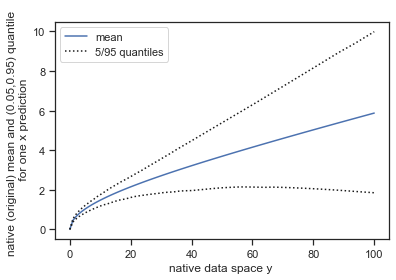

In [24]:
x_index = 0
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy[:,x_index,:],0).T,label='mean')
quantiles = plt.plot(model.data.sim_data.y_ind,np.quantile(predy[:,x_index,:],[0.05, 0.95],axis=0).T,'k:',label='5/95 quantiles')
plt.setp(quantiles[0], label="_") # set first line label to none for legend
plt.xlabel('native data space y ')
plt.ylabel('native (original) mean and (0.05,0.95) quantile \n for one x prediction')
plt.legend()
plt.show()

And below are similar predictions for the full models responses joint u and v

In [25]:
from sepia.SepiaPredict import SepiaFullPrediction
pred=SepiaFullPrediction(x, pred_samples, model)

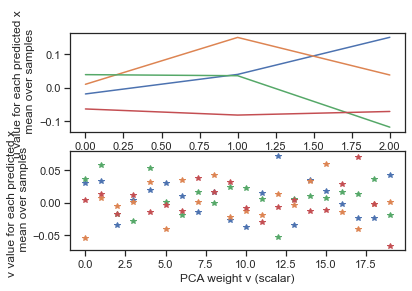

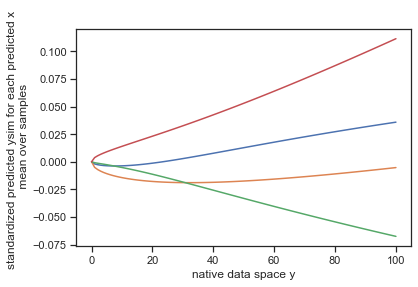

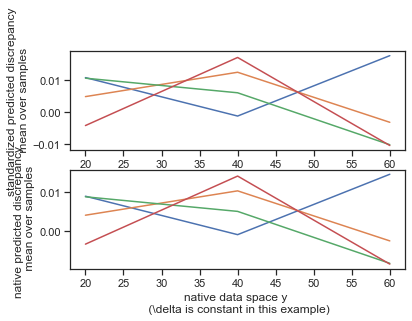

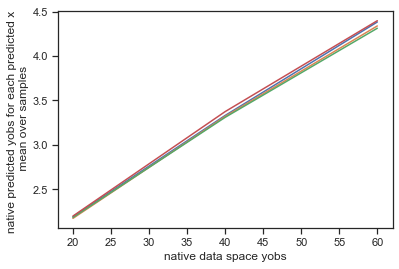

In [26]:
plt.figure()
predu, predv = pred.get_u_v()
plt.subplot(2,1,1)
plt.plot(np.mean(predu,0).T)
plt.xlabel('PCA weights u')
plt.ylabel('u value for each predicted x \n mean over samples')
plt.subplot(2,1,2)
plt.plot(np.mean(predv,0).T,'*')
plt.xlabel('PCA weight v (scalar)')
plt.ylabel('v value for each predicted x \n mean over samples')
plt.show()

predysimstd=pred.get_ysim(std=True)
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predysimstd,0).T)
plt.xlabel('native data space y')
plt.ylabel('standardized predicted ysim for each predicted x \n mean over samples')
plt.show()

preddstd=pred.get_discrepancy(std=True,as_obs=True)
predd=pred.get_discrepancy(as_obs=True)
plt.figure()
plt.subplot(2,1,1)
plt.plot(model.data.obs_data.y_ind,np.mean(preddstd,0).T)
plt.xlabel('native data space y \n (\delta is constant in this example)')
plt.ylabel('standardized predicted discrepancy\n mean over samples')
plt.subplot(2,1,2)
plt.plot(model.data.obs_data.y_ind,np.mean(predd,0).T)
plt.xlabel('native data space y \n (\delta is constant in this example)')
plt.ylabel('native predicted discrepancy \n mean over samples')
plt.show()

predyobs=pred.get_yobs(as_obs=True)
plt.figure()
plt.plot(model.data.obs_data.y_ind,np.mean(predyobs,0).T)
plt.xlabel('native data space yobs')
plt.ylabel('native predicted yobs for each predicted x \n mean over samples')
plt.show()

### Summary plot of predicted uncertainty for an observation.
The 5th prediction done corresponds to the observation in the model, with xpred=0.5.

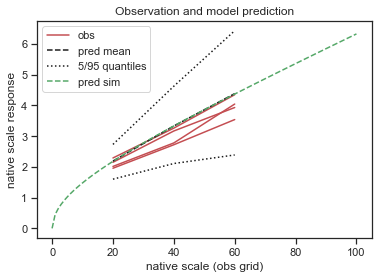

In [27]:
predysim=pred.get_ysim()
plt.figure()
obs = plt.plot(model.data.obs_data.y_ind,model.data.obs_data.y.T,'r',label='obs')
plt.setp(obs[1:], label="_")
plt.plot(model.data.obs_data.y_ind,np.mean(predyobs[:,x_index,:],0).T,'k--',label='pred mean')
quantiles = plt.plot(model.data.obs_data.y_ind,np.quantile(predyobs[:,x_index,:],[0.05, 0.95],axis=0).T,'k:',label='5/95 quantiles')
plt.setp(quantiles[0], label="_") # set first line label to none for legend
plt.plot(model.data.sim_data.y_ind,np.mean(predysim[:,x_index,:],0).T,'g--',label='pred sim')
plt.xlabel('native scale (obs grid)')
plt.ylabel('native scale response')
plt.title('Observation and model prediction')
plt.legend()
plt.show()